credit: https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([7, 7])
<class 'numpy.ndarray'>


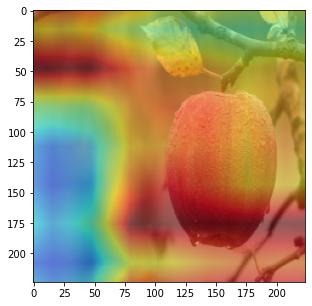

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize


class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet18(pretrained=True)
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out
        
        
gcmodel = GradCamModel()

img = imread('/content/apple2.jpg') 

img = resize(img, (224,224), preserve_range = True)
img = np.expand_dims(img.transpose((2,0,1)),0)
img /= 255.0
# mean = np.array([0.485])
# std = np.array([0.229])
mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
img = (img - mean)/std
inpimg = torch.from_numpy(img).to(torch.float32)

out, acts = gcmodel(inpimg)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600])))
loss.backward()
grads = gcmodel.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
for i in range(acts.shape[1]):
 acts[:,i,:,:] += pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max

heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)     

#For color image
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.5);print(type(img))
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow((img*std+mean)[0].transpose(1,2,0))
axs.imshow(heatmap_j2)
plt.show()



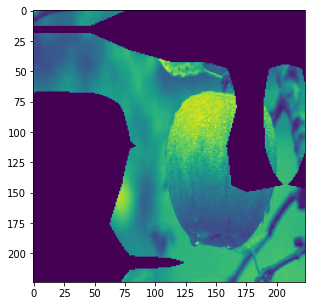

In [2]:
#For single channel image
heatmap_j3 = (heatmap_j > 0.70)
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(((img*std+mean)[0][0])*heatmap_j3)

plt.show()